In [1]:
!pip install imgaug

In [14]:
import os
import cv2
import imageio
import imgaug as ia
import matplotlib.pyplot as plt
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
ia.seed(1)

In [5]:
# Load the dataset
image_dir = "./sea-turtles-1-test/all/images/"
label_dir = "./sea-turtles-1-test/all/labels/"
image_files = os.listdir(image_dir)

In [10]:
# Only load the first 20 images with annotations
image_files = [image_file for image_file in image_files if os.path.exists(os.path.join(label_dir, image_file.replace(".jpg", ".txt")))]

In [13]:
# Select the first 20 images
image_files = image_files[:20]

img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.68359375, 0.30625, 0.01796875, 0.03984375]
img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.6828125, 0.4015625, 0.01484375, 0.03046875]
img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.65, 0.51328125, 0.01796875, 0.03046875]
img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.634375, 0.55390625, 0.01875, 0.0328125]
img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.659375, 0.61484375, 0.021875, 0.03359375]
img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.6296875, 0.74609375, 0.01328125, 0.0328125]
img  ./sea-turtles-1-test/all/images/001.jpg  - label =  [0.0, 0.634375, 0.8953125, 0.01796875, 0.0296875]
img  ./sea-turtles-1-test/all/images/002.jpg  - label =  [0.0, 0.4515625, 0.6390625, 0.0109375, 0.01171875]
img  ./sea-turtles-1-test/all/images/002.jpg  - label =  [0.0, 0.4640625, 0.43984375, 0.01015625, 0.01015625]


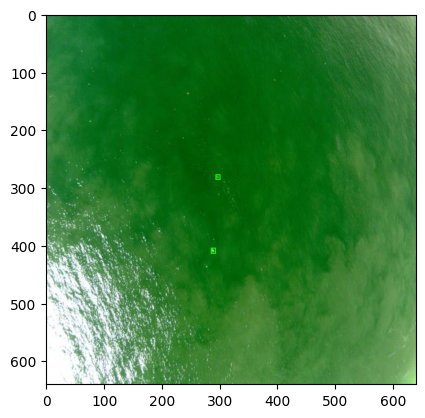

In [30]:
for image_file in image_files:
    # Load the image
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, c = image.shape

     # Load the corresponding annotation file
    annotation_file = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))
    with open(annotation_file, 'r') as file:
        list_bbs = []
        for line in file:

            # Assuming each line of the annotation file contains [class, xmin, ymin, xmax, ymax]
            annotation = [float(coord) for coord in line.strip().split()]
            print('img ',image_path,' - label = ', annotation)
    
            # Extract the bounding box coordinates
            class_id, center_x, center_y, width, height = annotation
            x1=(center_x-(width/2))*w
            x2=(center_x+(width/2))*w
            y1=(center_y-(height/2))*h
            y2=(center_y+(height/2))*h

            bb = BoundingBox(x1=x1,x2=x2,y1=y1,y2=y2)

            list_bbs.append(bb)
        bbs = BoundingBoxesOnImage(list_bbs, shape=image.shape)

    #print(annotation)
    plt.imshow(bbs.draw_on_image(image, size=2))

In [16]:
image

array([[[218, 136,   4],
        [228, 146,  15],
        [224, 141,  12],
        ...,
        [244, 152,  23],
        [245, 153,  24],
        [241, 149,  20]],

       [[213, 131,   0],
        [222, 139,  10],
        [219, 135,   9],
        ...,
        [243, 152,  23],
        [242, 151,  22],
        [244, 153,  24]],

       [[220, 137,   8],
        [226, 143,  14],
        [222, 138,  12],
        ...,
        [237, 151,  21],
        [234, 147,  19],
        [239, 152,  24]],

       ...,

       [[125,  88,  32],
        [130,  94,  34],
        [126,  92,  26],
        ...,
        [194, 154,  35],
        [191, 150,  28],
        [193, 152,  30]],

       [[128,  90,  32],
        [134,  98,  34],
        [133, 101,  28],
        ...,
        [210, 170,  52],
        [208, 165,  48],
        [208, 165,  48]],

       [[124,  87,  27],
        [132,  97,  31],
        [135, 105,  28],
        ...,
        [217, 176,  60],
        [213, 169,  54],
        [208, 164,  49]]